In [1]:
# Targets:
# 0 = normal
# 1 = mass

In [2]:
import pandas as pd
import numpy as np
import os


import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm

# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
#import tqdm.notebook as tq
#for i in tq.tqdm(...):

from tqdm import tqdm_notebook as tqdm


import gc


import albumentations as albu
from albumentations import Compose


from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, jaccard_score
import itertools


# load image with Pillow
from PIL import Image

from numpy import asarray

from skimage.transform import resize


import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.11.0+cpu
0.12.0+cpu


In [3]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [4]:
base_path = '../input/smart-mammo-data/'


In [5]:
os.listdir('../input/smart-mammo-data')

['df_data_bens.csv',
 'v2_images_dir',
 'exp06-spine-prepare-the-images-original-size.ipynb',
 'df_data.csv',
 'VinDR-Mammo-Data',
 'images_dir',
 'df_data_padded.csv',
 'exp33_best.pt',
 'Exp_51-VAST',
 'bens_images_dir',
 'Exp_50-VAST',
 'data_for_simulation',
 'exp17-LOCAL-pad--prepare-the-images-original-size.ipynb']

## Config

In [6]:
# Yolo setup:
NUM_EPOCHS = 90 #80
BATCH_SIZE = 10 #32
IMAGE_SIZE = 1024 # Yolo will automatically resize the input images to this size.

# This is the fold that Yolo is trained on
CHOSEN_FOLD = 0

NUM_FOLDS = 5

NUM_CORES = os.cpu_count()
NUM_CORES

4

## Set up Yolov5 - For offline use

The Yolov5 model being used here needs to have the internet turned for training to work. However, it does not need to have the internet on during inference.

In [7]:
# Copy the yolov5 folder from the notebook to  /kaggle/working/

# We will use yolov5-v5.0 for the ensembling

if os.path.isdir('/kaggle/working/yolov5') == False:

    shutil.copytree('../input/my-yolov5-for-offline-use/yolov5-v5.0', '/kaggle/working/yolov5')

In [8]:
!ls

__notebook__.ipynb  yolov5


## Load the train data

In [9]:
# This is the fold data that both models were trained on.
path = '../input/exp49-mammo-create-the-10-folds/df_data_w_folds.csv'

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(1426, 20)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target,fold
0,517563a43eab4f90efc650fcb0d215d5,37d2595b7ec81bd31a18d26afdb0aabf,c54fbe3a374b9e157280479c4649b11a,L,MLO,2812,2012,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,test,../input/smart-mammo-data/images_dir/images_di...,1,0,2.0
1,f8894c9173aaa865bd43751eeeacd3b0,1225d3a302306aca94552c0f8c30fe2c,78dfa5f3dd380341cc17955f52279728,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,test,../input/smart-mammo-data/images_dir/images_di...,1,0,2.0
2,05783bf55ed93d5ec21d4e0e8546a5f0,da0aae7d4ed0388e3e15da1fd90af2e1,f9c2fd2f75598e0d7c311687693c31a7,R,CC,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,5.0
3,ea8a09a16763d310b4065fe94c6c04cd,b714ced6a887a6528768db77b239dcd9,58d70109b957243aeaf19b95ed5322d4,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,3.0
4,38c28cfa153bb4a7a1ade330738df1b7,9b0f078012d78f9ddc0fe2482a33bf28,6cf20761dccfd17caa6ae4877b744db5,R,CC,2812,2012,BI-RADS 1,DENSITY D,['No Finding'],NaN,NaN,NaN,NaN,NaN,test,../input/smart-mammo-data/images_dir/images_di...,1,0,7.0


In [10]:
df_data['target'].value_counts()

1    1226
0     200
Name: target, dtype: int64

## Process the train data

In [11]:
# Get the path to each image

def get_path(row):
    
    study_id = row['study_id']
    image_id = row['image_id']
    path = base_path + 'images_dir/images_dir/' + image_id + '.dicom'
    
    return path


df_data['path'] = df_data.apply(get_path, axis=1)

print(df_data.shape)

#df_data.head()

(1426, 20)


In [12]:
# Targets:
# 0 = normal
# 1 = fracture

df_data['target'].value_counts()

1    1226
0     200
Name: target, dtype: int64

## Create a column for the bbox info

In [13]:
# Put the bbox info for each image into a list of bbox dicts


bbox_list = []

for i in range(0, len(df_data)):
    
    target = df_data.loc[i, 'target']
    study_slice = df_data.loc[i, 'image_id']
    
    if target == 1:
    
        xmin = df_data.loc[i, 'xmin']
        ymin = df_data.loc[i, 'ymin']
        xmax = df_data.loc[i, 'xmax']
        ymax = df_data.loc[i, 'ymax']
        
        x = round(xmin)
        y = round(ymin)
        width = round(xmax - xmin)
        height = round(ymax - ymin)

        bbox_dict ={
            'x': x,
            'y': y,
            'width': width,
            'height': height
        }

        bbox_list.append(bbox_dict)
        
    else:
        bbox_list.append('none')
        
        
# Add the bbox_list to df_data

df_data['boxes'] = bbox_list

#print(df_data.shape)

#df_data.head()

## Create df_train and df_val

In [14]:
# Choose the fold to train on.
fold_index = CHOSEN_FOLD

df_train = df_data[df_data['fold'] != fold_index]
df_val = df_data[df_data['fold'] == fold_index]

print(df_train['target'].value_counts())
print('')
print(df_val['target'].value_counts())

1    1100
0     180
Name: target, dtype: int64

1    126
0     20
Name: target, dtype: int64


## Helper functions

In [15]:
# Confusion matrix where the size of the plot and the text size can be changed

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=text_size)

    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.tight_layout()

In [16]:
# Source: https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px

from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data




def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

## Make a prediction on the val set

In [17]:
# Create a folder to store the extracted files
if os.path.isdir('yolo_images_dir') == False:
    yolo_images_dir = 'yolo_images_dir'
    os.mkdir(yolo_images_dir)
    
    
    
val_fname_list = list(df_val['image_id'])

for image_id in val_fname_list:
    
    fname = image_id + '.png'
    
    # Copy the image to images
    # Set the path to the images here.
    shutil.copyfile(
        f"{base_path}/images_dir/images_dir/{fname}",
        f"yolo_images_dir/{fname}")
    
    
len(os.listdir('yolo_images_dir'))

132

In [18]:
!ls

__notebook__.ipynb  yolo_images_dir  yolov5


In [19]:
# change the working directory
os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [20]:
# Make a prediction on all images in images_dir

# The model only creates a txt file if it finds objects on an image.

test_images_path = '/kaggle/working/yolo_images_dir'
#yolo_model_path = '/kaggle/working/best.pt'
exp50_model_path = '/kaggle/input/smart-mammo-data/Exp_50-VAST/exp50_best.pt'
exp51_model_path = '/kaggle/input/smart-mammo-data/Exp_51-VAST/exp51_best.pt'

# Ensembling two Yolo models
# How to ensemble Yolov5 models:
# Ref: https://github.com/ultralytics/yolov5/issues/318

!python detect.py --source $test_images_path --weights $exp50_model_path $exp51_model_path --img $IMAGE_SIZE --save-txt --save-conf --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=1024, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/working/yolo_images_dir', update=False, view_img=False, weights=['/kaggle/input/smart-mammo-data/Exp_50-VAST/exp50_best.pt', '/kaggle/input/smart-mammo-data/Exp_51-VAST/exp51_best.pt'])
Fusing layers... 
Fusing layers... 
Ensemble created with ['/kaggle/input/smart-mammo-data/Exp_50-VAST/exp50_best.pt', '/kaggle/input/smart-mammo-data/Exp_51-VAST/exp51_best.pt']

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/132 /kaggle/working/yolo_images_dir/008c66563c73b2f5b8e42915b2cd6af5.png: 1024x736 1 

## Process the predictions

In [21]:
txt_files_list = os.listdir('runs/detect/exp/labels')

print(len(txt_files_list))
print(txt_files_list[0])

90
01fb871dc222684a9950609b62b76772.txt


In [22]:
# Put the info inside all the txt files into one dataframe.
# Remember that if the image does not have any bounding boxes
# then Yolo does not create a txt file for it.

txt_files_list = os.listdir('runs/detect/exp/labels')

for i, txt_file in enumerate(txt_files_list):
    
    # set the path
    path = f'runs/detect/exp/labels/{txt_file}'
    
    # create a list of column names
    cols = ['class', 'x-center', 'y-center', 'bbox_width', 'bbox_height', 'conf-score']

    # put the file contents into a dataframe
    df = pd.read_csv(path, sep=" ", header=None)
    
    # add the column names to the datafrae
    df.columns = cols
    
    # Split the txt fname on the full stop and choose the first item 
    # in the list. The add the .jpg extension.
    # 87a0829f53c1.txt becomes 87a0829f53c1_image
    #fname = txt_file.split('.')[0] + '.png'
    fname = txt_file.replace("txt", "png")
    
    # add a new column with the fname
    df['id'] = fname
 
    # stack the dataframes for each txt file
    if i == 0:
        
        df_test_preds = df
    else:
        
        df_test_preds = pd.concat([df_test_preds, df], axis=0)
       
    
    
print(len(txt_files_list))
print(df_test_preds['id'].nunique())
print(df_test_preds.shape)

df_test_preds.head()

90
90
(105, 7)


,class,x-center,y-center,bbox_width,bbox_height,conf-score,id
0,1,0.228750,0.416998,0.064643,0.055145,0.303736,01fb871dc222684a9950609b62b76772.png
0,1,0.775357,0.465463,0.117857,0.102615,0.523016,e788be650ac8e1f81beda55451f217e3.png
0,1,0.046786,0.687749,0.076429,0.060546,0.270443,07f468d6fff5b3e3b512e4b95cf0cdda.png
1,1,0.286429,0.511228,0.113571,0.086128,0.281382,07f468d6fff5b3e3b512e4b95cf0cdda.png
0,1,0.807143,0.416572,0.110000,0.089539,0.281311,074775a9e94c93ed3ee32a82d2864c68.png


In [23]:
# Add the predictions to df_val

# reset the index
df_val = df_val.reset_index(drop=True)

# create a new column called 'id'
df_val['id'] =  df_val['image_id'] + '.png'

val_pred_list = []
pred_rel_bbox_list = []

pred_list = list(df_test_preds['id'])

for i in range(0, len(df_val)):
    
    #fname = df_val.loc[i, 'study_slice']
    #fname = study_slice + '.png'
    
    # get the fname
    fname = df_val.loc[i, 'id']
    
    # The fname will only be in the pred list if Yolo created a txt file for the val image.
    # Yolo will only create a txt file if a fracture was detected on the image.
    if fname in pred_list:
        
        val_pred_list.append(1)

    else:
        val_pred_list.append(0)
    
    
df_val['preds'] = val_pred_list

# Check the distribution of the predicted classes
df_val['preds'].value_counts()

1    103
0     43
Name: preds, dtype: int64

In [24]:
df_val.columns

Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density',
       'finding_categories', 'finding_birads', 'xmin', 'ymin', 'xmax', 'ymax',
       'split', 'path', 'num_findings', 'target', 'fold', 'boxes', 'id',
       'preds'],
      dtype='object')

## Convert the true bboxes into masks

In [25]:
!pwd

/kaggle/working/yolov5


In [26]:
# change the working directory
os.chdir('/kaggle/working/')

!pwd

/kaggle/working


In [27]:
# Create a folder to store the true val masks

if os.path.isdir('true_masks_dir') != True:
    
    true_masks_dir = 'true_masks_dir'
    os.mkdir(true_masks_dir)
    
!ls

__notebook__.ipynb  true_masks_dir  yolo_images_dir  yolov5


In [28]:
# Create true val masks

df = df_val.reset_index(drop=True)

saved_list = []

for index in tqdm(range(0, len(df)), total=len(df)):
    
    target = df.loc[index, 'target']
    
    image_id = df.loc[index, 'image_id']
    
    fname = image_id + '.png'
    
    # Read the image using cv2.
    # We use cv2 because it's the fastest by far.
    # But be careful. Keep in mind that cv2 uses a (width, height) input format
    # instead of the (height, width) format used by matplotlib.
    # Also, cv2 reads images in BGR format by default instead of RGB.
    # If your images look blue then they have been read in BGR format.
    path = base_path + 'images_dir/images_dir/' + image_id + '.png'
    image = cv2.imread(path)
    
    # cv2 reads in BGR format therefore convert from BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # create a blank mask
    mask = np.zeros((image.shape[0], image.shape[1]))
    
    # Only create a mask if the target is 1 else the
    # blank mask will be saved.
    if target == 1:
        
        if fname not in saved_list:

            x = round(df.loc[index, 'xmin'])
            y = round(df.loc[index, 'ymin'])
            xmax = round(df.loc[index, 'xmax'])
            ymax = round(df.loc[index, 'ymax'])

            w = xmax - x
            h = ymax - y

            # Add the bbox mask to the blank mask created above.
            # Remember that in images the origin coord (0,0) is
            # in the top left corner and not in the botton left corner
            # like on a graph.
            mask[y:y+h, x:x+w] = 1
            
        else: # Some images have more than on bbox
            
            # Load the previously saved mask
            path = 'true_masks_dir/' + fname
            mask = plt.imread(path)
            
            x = round(df.loc[index, 'xmin'])
            y = round(df.loc[index, 'ymin'])
            xmax = round(df.loc[index, 'xmax'])
            ymax = round(df.loc[index, 'ymax'])

            w = xmax - x
            h = ymax - y

            # Add the bbox mask to the blank mask created above.
            # Remember that in images the origin coord (0,0) is
            # in the top left corner and not in the botton left corner
            # like on a graph.
            mask[y:y+h, x:x+w] = 1
            
    
    # Save the mask as an image in the folder
    # that we created.
    #fname = image_id + '.png'
    dst = os.path.join(true_masks_dir, fname)
    
    cv2.imwrite(dst, mask)
    
    saved_list.append(fname)
    
    

# Check how mane files are in the new directory

file_list = os.listdir('true_masks_dir')

len(file_list)

  0%|          | 0/146 [00:00<?, ?it/s]

132

(3518, 2800)


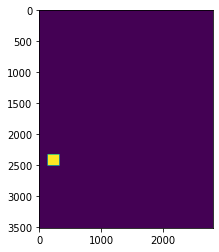

In [29]:
true_mask_list = os.listdir('true_masks_dir')

i = 0

path = 'true_masks_dir/' + true_mask_list[i]

image = plt.imread(path)

print(image.shape)

plt.imshow(image)

## Convert the pred bboxes into masks

In [30]:
df_test_preds.head()

,class,x-center,y-center,bbox_width,bbox_height,conf-score,id
0,1,0.228750,0.416998,0.064643,0.055145,0.303736,01fb871dc222684a9950609b62b76772.png
0,1,0.775357,0.465463,0.117857,0.102615,0.523016,e788be650ac8e1f81beda55451f217e3.png
0,1,0.046786,0.687749,0.076429,0.060546,0.270443,07f468d6fff5b3e3b512e4b95cf0cdda.png
1,1,0.286429,0.511228,0.113571,0.086128,0.281382,07f468d6fff5b3e3b512e4b95cf0cdda.png
0,1,0.807143,0.416572,0.110000,0.089539,0.281311,074775a9e94c93ed3ee32a82d2864c68.png


In [31]:
# Create a folder to store the true val masks

if os.path.isdir('pred_masks_dir') != True:
    
    pred_masks_dir = 'pred_masks_dir'
    os.mkdir(pred_masks_dir)
    
!ls

__notebook__.ipynb  pred_masks_dir  true_masks_dir  yolo_images_dir  yolov5


In [32]:
df_test_preds['id'].nunique()

90

In [33]:
saved_list = []

df_test_preds = df_test_preds.reset_index(drop=True)

for i in tqdm(range(0, len(df_test_preds)), total=len(df_test_preds)):
    
    fname = df_test_preds.loc[i, 'id']
    
    # Read the image
    path = base_path + 'images_dir/images_dir/' + fname
    
    image = cv2.imread(path)
    
    # cv2 reads in BGR format therefore convert from BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # create a blank mask
    mask = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)
    

        
    if fname not in saved_list:

        # image_png_size_list: [(h,w), ...]
        orig_image_h = image.shape[0]
        orig_image_w = image.shape[1]


        w = int(df_test_preds.loc[i,'bbox_width'] * orig_image_w)
        h = int(df_test_preds.loc[i,'bbox_height'] * orig_image_h)

        x_cent = orig_image_w * df_test_preds.loc[i,'x-center']
        y_cent = orig_image_h * df_test_preds.loc[i,'y-center']

        x = int(x_cent - (w / 2))
        y = int(y_cent - (h / 2))

        xmax = xmin + w
        ymax = ymin + h

        # Add the bbox mask to the blank mask created above.
        # Remember that in images the origin coord (0,0) is
        # in the top left corner and not in the botton left corner
        # like on a graph.
        mask[y:y+h, x:x+w] = 1

    else: # some pred images have more than one mask

        # Load the previous mask
        # Read the image
        path = 'pred_masks_dir/' + fname
        mask = plt.imread(path)

        # image_png_size_list: [(h,w), ...]
        orig_image_h = image.shape[0]
        orig_image_w = image.shape[1]


        w = int(df_test_preds.loc[i,'bbox_width'] * orig_image_w)
        h = int(df_test_preds.loc[i,'bbox_height'] * orig_image_h)

        x_cent = orig_image_w * df_test_preds.loc[i,'x-center']
        y_cent = orig_image_h * df_test_preds.loc[i,'y-center']

        x = int(x_cent - (w / 2))
        y = int(y_cent - (h / 2))

        xmax = xmin + w
        ymax = ymin + h

        # Add the bbox mask to the blank mask created above.
        # Remember that in images the origin coord (0,0) is
        # in the top left corner and not in the botton left corner
        # like on a graph.
        mask[y:y+h, x:x+w] = 1
        
    
    # Save the mask as an image in the folder
    # that we created.
    dst = os.path.join(pred_masks_dir, fname)
    
    cv2.imwrite(dst, mask)
    
    saved_list.append(fname)
    

# Check how mane files are in the new directory
file_list = os.listdir('pred_masks_dir')

len(file_list)

  0%|          | 0/105 [00:00<?, ?it/s]

90

In [34]:
# Create blank masks for all val images for which
# no bboxes were predicted.
# Store these masks in pred_masks_dir

pred_list = list(df_test_preds['id'])

for i in tqdm(range(0, len(df_val)), total=len(df_val)):
    
    fname = df_val.loc[i, 'id']
    
    if fname not in pred_list:
        
        path = base_path + 'images_dir/images_dir/' + fname
        image = cv2.imread(path)

        # cv2 reads in BGR format therefore convert from BGR to RGB.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # create a blank mask
        mask = np.zeros((image.shape[0], image.shape[1]))
        
        # Save the blank mask in pred_nasks_dir
        dst = os.path.join(pred_masks_dir, fname)

        cv2.imwrite(dst, mask)
        
        
# Check how mane files are in the new directory
file_list = os.listdir('pred_masks_dir')

len(file_list)

  0%|          | 0/146 [00:00<?, ?it/s]

132

In [35]:
df_val['id'].nunique()

132

(3518, 2800)


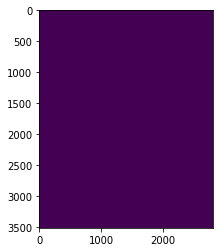

In [36]:
pred_mask_list = os.listdir('pred_masks_dir')

i = 21

path = 'true_masks_dir/' + pred_mask_list[i]

image = plt.imread(path)

print(image.shape)

plt.imshow(image)

## Test the iou code

In [37]:
def calculate_iou(y_true, y_pred):
    
    """
    Input: Numpy arrays with shape (image_h, image_w)
    Values must be either 1 or 0.
    
    Output: IOU value as a number.
    
    
    This works only for single images and not
    for a batch of images.
    """
    

    # If both images are blank
    if y_true.max() == 0 and y_pred.max() == 0:
        
        IOU = 'both_blank'
        
    else:
    
        # Set the matrix values to be either 1 or 0.
        # This can also be done like this: mask = (mask > 0).astype(np.uint8)
        y_true = y_true.astype(np.bool)
        y_pred = y_pred.astype(np.bool)

        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()

        result = (y_true_flat * y_pred_flat)

        area_of_intersection = np.sum(result)

        area_of_union = (np.sum(y_true_flat) + np.sum(y_pred_flat)) - area_of_intersection

        # add 0.00001 to prevent a zero division error.
        IOU = (area_of_intersection)/(area_of_union + 0.00001)

        # Round to three decimal places
        IOU = round(IOU, 3)
    
    return IOU


(3518, 2800)
float32
0.0
0.003921569


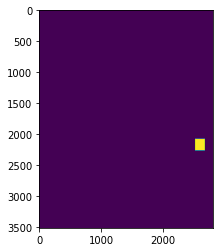

In [38]:
# Test the IOU function

pred_mask_list = os.listdir('pred_masks_dir')

i = 10

path = 'true_masks_dir/' + pred_mask_list[i]

mask = plt.imread(path) #.astype(np.bool)

# Threshold the mask
#mask = (mask > 0).astype(np.uint8)

print(mask.shape)
print(mask.dtype)
print(mask.min())
print(mask.max())

plt.imshow(mask)

In [39]:
# Change all values to zero
mask1 = mask * 0

In [40]:
# *** Note that if both masks are blank then the iou returned is 0.

y_true = mask1
y_pred = mask1

iou = calculate_iou(y_true, y_pred)

iou

'both_blank'

## Calculate the IOU for all val rows

In [41]:
iou_list = []

for i in tqdm(range(0, len(df_val)), total=len(df_val)):
    
    # Get the fname
    fname = df_val.loc[i, 'id']
    
    # Load the mask from true_masks_dir
    path = 'true_masks_dir/' + fname
    true_mask = plt.imread(path)
    
    
    # Load the pred mask
    path =  'pred_masks_dir/' + fname
    pred_mask = plt.imread(path)
    
    # Calculate the iou
    iou = calculate_iou(true_mask, pred_mask)
    
    iou_list.append(iou)
    
    
# Add iou list to df_val
df_val['iou'] = iou_list

  0%|          | 0/146 [00:00<?, ?it/s]

In [42]:
df = df_val[df_val['iou'] != 'both_blank']

print(df['iou'].min())
print(df['iou'].max())
print(df['iou'].mean())

0.0
0.914
0.4223358778625952


## Adjust the preds

There are cases where the true image does ontain a bbox, and the model also predicted a bbox for that image - but the pred bbox did not overlap with the true bbox. In those cases we need to change the pred from 1 to 0.

In [43]:
df_val.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,ymax,split,path,num_findings,target,fold,boxes,id,preds,iou
0,b4fe06383379a0760f9086dae96f7309,107744bf8d951e85014716913012ab1a,9a728250069ba3419ccc1f35b94bd252,L,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],...,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,0.0,none,9a728250069ba3419ccc1f35b94bd252.png,0,both_blank
1,00c3c05f7ff415d71fae16ae999c178d,f27d5f20db2d58ed5729d1f3d78c54c0,033e4f9ee05749cd591c958aa873dc8b,L,CC,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],...,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,0.0,none,033e4f9ee05749cd591c958aa873dc8b.png,0,both_blank
2,1749223c9b8005f17587fe51a62c6af7,99b93f91510bce11c6986374a18624ed,b7d9bfff242190b8793b2a412ae1d68e,R,CC,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],...,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,0.0,none,b7d9bfff242190b8793b2a412ae1d68e.png,1,0.0
3,46293ae7e87ee76a172f0ac1b2d06ea5,064776530dbd717b0c1975a6357af8e4,c99fc0b9b7bc0618d0b156db5d1905d8,L,CC,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],...,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,0.0,none,c99fc0b9b7bc0618d0b156db5d1905d8.png,0,both_blank
4,c37a433bcaacd344775af66d571c7471,b8ab27600b5c3634f0785f88f44fbff7,7147d78a9fef08b6eba38c0cae4d822f,L,CC,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],...,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,0.0,none,7147d78a9fef08b6eba38c0cae4d822f.png,0,both_blank


In [44]:
df_val['preds'].value_counts()

1    103
0     43
Name: preds, dtype: int64

In [45]:
def check_pred_iou(row):
    
    target = row['target']
    pred = row['preds']
    iou = row['iou']
    
    if target == 1 and pred == 1:
        
        if iou > 0:
            return pred # pred is 1
        else:
            return 0
    else:
        
        return pred

        
df_val['iou_preds'] = df_val.apply(check_pred_iou, axis=1)


In [46]:
df_val['iou_preds'].value_counts()

1    85
0    61
Name: iou_preds, dtype: int64

## Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix

CLASS_LIST = ['Normal', 'Mass']
    
# targets
y_true = list(df_val['target'])

# get the preds as integers
y_pred = list(df_val['iou_preds'])

# argmax returns the index of the max value in each row.
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix.
print()
print(cm)
print(CLASS_LIST)


[[15  5]
 [46 80]]
['Normal', 'Mass']


Confusion matrix, without normalization
[[15  5]
 [46 80]]


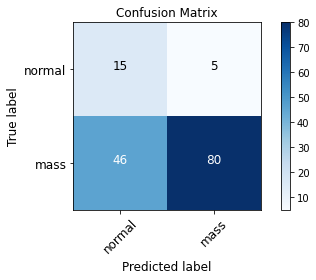

In [48]:
cm_plot_labels = ['normal', 'mass']

# Set the size of the plot.
#plt.figure(figsize=(10,7))

# Set the size of the text
text_size=12

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', text_size=text_size)

## Classification Report

In [49]:
from sklearn.metrics import classification_report
    
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print()
print(report)


              precision    recall  f1-score   support

      normal       0.25      0.75      0.37        20
        mass       0.94      0.63      0.76       126

    accuracy                           0.65       146
   macro avg       0.59      0.69      0.56       146
weighted avg       0.85      0.65      0.71       146



### Precision

Given a prediction, what is the probability that the prediction is correct. In other words, how much can we trust a prediction made by the model?

### Recall

What percentage of the total number of objects did the model detect? Given an object, what is the probability that the model will detect it? Example: Did the computer vision model in the self driving car detect all the pedestrians?

## Delete images to prevent notebook commit errors

In [50]:
# change the working directory to yolov5

os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [51]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('base_dir') == True:
    shutil.rmtree('base_dir')

In [52]:
# change the working directory

os.chdir('/kaggle/working/')

!pwd

/kaggle/working


In [53]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('images_dir') == True:
    shutil.rmtree('images_dir')
    
if os.path.isdir('val_images_dir') == True:
    shutil.rmtree('val_images_dir')

In [54]:
!ls

__notebook__.ipynb  pred_masks_dir  true_masks_dir  yolo_images_dir  yolov5


In [55]:
25716/60/60

7.1433333333333335